# Previsión de falla

    Descripción
        Los galpones de Full de mercado libre cuentan con una flota de dispositivos que transmiten
        diariamente telemetría agregada en varios atributos.
        Las técnicas de mantenimiento predictivo están diseñadas para ayudar a determinar la
        condición del equipo de mantenimiento en servicio para predecir cuándo se debe realizar el
        mantenimiento. Este enfoque promete ahorros de costos sobre el mantenimiento preventivo
        de rutina o basado en el tiempo porque las tareas se realizan solo cuando están justificadas.
    Entregable
        Tiene la tarea de generar una Jupyter notebook con un modelo predictivo para predecir la
        probabilidad de falla del dispositivo con el objetivo de bajar los costos del proceso. Como
        una referencia, una falla de un dispositivo tiene un costo de 1 mientras el costo de un
        mantenimiento es 0,5. El archivo "full_devices.csv" tiene los valores diários para los 9
        atributos de los dispositivos y la columna que está tratando de predecir se llama 'failure' con
        el valor binario 0 para no fallar y 1 para fallar.

In [1]:
# bibliotecas
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm

In [2]:
# Importação de tabelas
falhas = pd.read_csv('full_devices.csv', encoding="ISO-8859-1")
falhas

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


In [3]:
# informações sobre a tabela
falhas.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        124494 non-null  object
 1   device      124494 non-null  object
 2   failure     124494 non-null  int64 
 3   attribute1  124494 non-null  int64 
 4   attribute2  124494 non-null  int64 
 5   attribute3  124494 non-null  int64 
 6   attribute4  124494 non-null  int64 
 7   attribute5  124494 non-null  int64 
 8   attribute6  124494 non-null  int64 
 9   attribute7  124494 non-null  int64 
 10  attribute8  124494 non-null  int64 
 11  attribute9  124494 non-null  int64 
dtypes: int64(10), object(2)
memory usage: 25.2 MB


In [4]:
# análise descritiva multivariada dos valores da tabela
data_describe = falhas.describe(exclude=[object]).T
pd.options.display.float_format = '{:20,.2f}'.format                  #supressão de notação científica
data_describe

,count,mean,std,min,25%,50%,75%,max
failure,"124,494.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
attribute1,"124,494.00","122,388,103.24","70,459,334.22",0.00,"61,284,762.00","122,797,388.00","183,309,640.00","244,140,480.00"
attribute2,"124,494.00",159.48,"2,179.66",0.00,0.00,0.00,0.00,"64,968.00"
attribute3,"124,494.00",9.94,185.75,0.00,0.00,0.00,0.00,"24,929.00"
attribute4,"124,494.00",1.74,22.91,0.00,0.00,0.00,0.00,"1,666.00"
attribute5,"124,494.00",14.22,15.94,1.00,8.00,10.00,12.00,98.00
attribute6,"124,494.00","260,172.66","99,151.08",8.00,"221,452.00","249,799.50","310,266.00","689,161.00"
attribute7,"124,494.00",0.29,7.44,0.00,0.00,0.00,0.00,832.00
attribute8,"124,494.00",0.29,7.44,0.00,0.00,0.00,0.00,832.00
attribute9,"124,494.00",12.45,191.43,0.00,0.00,0.00,0.00,"18,701.00"


Alguns dos atributos (variáveis preditoras) apresentam valores muito inferiores a outros de maior impacto na variável alvo, podem assim acabar sendo representados pelo termo de erro da equação.

In [5]:
# análise descritiva dos objetos tabela
falhas.describe(exclude=[np.number]).T

,count,unique,top,freq
date,124494,304,2015-01-01,1163
device,124494,1169,Z1F0QLC1,304


<Axes: >

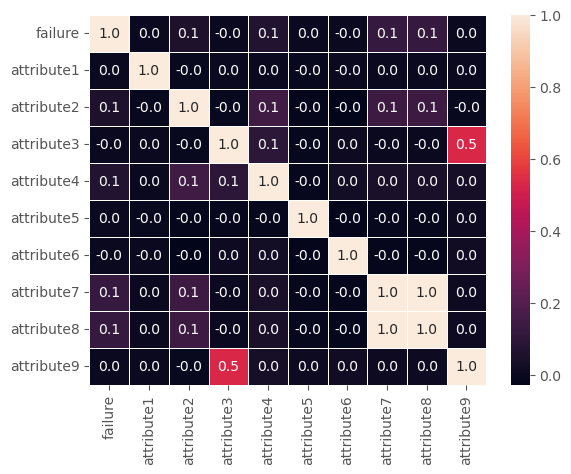

In [6]:
# estudo de correlações de perason
failure = falhas.loc[:,['failure', 'attribute1', 'attribute2', 'attribute3', 'attribute4'
                       , 'attribute5', 'attribute6', 'attribute7', 'attribute8', 'attribute9']]
correlation = failure.corr()

# plotagem da matriz
cor = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=.6)
cor

Com a dicotimização da variével fica realmento complicado entender as relações entre as variáveis, apesar de o estudo ter apresentado alguns resultados interesantes como a altíssima relação entre os atributo 7 e 8 e alguma reção entre os atributos 3 e 9.

### Regressão Linear Múltipla - One Hot Encoding

In [7]:
# Dummização da virável afim de evitar ponderação arbitrária - PROCEDIMENTO N-1 DUMMIES
hot_data = pd.get_dummies(falhas, columns = ['failure'], drop_first = True) 
hot_data

,date,device,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9,failure_1
0,2015-01-01,S1F01085,215630672,56,0,52,6,407438,0,0,7,False
1,2015-01-01,S1F0166B,61370680,0,3,0,6,403174,0,0,0,False
2,2015-01-01,S1F01E6Y,173295968,0,0,0,12,237394,0,0,0,False
3,2015-01-01,S1F01JE0,79694024,0,0,0,6,410186,0,0,0,False
4,2015-01-01,S1F01R2B,135970480,0,0,0,15,313173,0,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,18310224,0,0,0,10,353705,8,8,0,False
124490,2015-11-02,Z1F0Q8RT,172556680,96,107,4,11,332792,0,0,13,False
124491,2015-11-02,Z1F0QK05,19029120,4832,0,0,11,350410,0,0,0,False
124492,2015-11-02,Z1F0QL3N,226953408,0,0,0,12,358980,0,0,0,False


In [8]:
# modelagem
x_v = hot_data[['attribute1']]
y_v = hot_data[['failure_1']]
modelo_hot_data = LinearRegression().fit(x_v, y_v)

# Parâmetros
params = np.append(modelo_hot_data.intercept_,modelo_hot_data.coef_)
summary = sm.OLS(y_v, sm.add_constant(x_v)).fit()
print(summary.summary())

                            OLS Regression Results                            
Dep. Variable:              failure_1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4898
Date:                Mon, 26 Feb 2024   Prob (F-statistic):              0.484
Time:                        23:35:52   Log-Likelihood:             2.6340e+05
No. Observations:              124494   AIC:                        -5.268e+05
Df Residuals:                  124492   BIC:                        -5.268e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.532      0.0